In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

from os import listdir
from os.path import isfile, join

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [151]:
df_work = pd.read_csv('labels_and_features_paws.csv')
df_work.head()

,name,q_Imax,Imax_over_Imean,Imax_over_Ilowq,Imax_over_Ihighq,Imax_sharpness,low_q_ratio,high_q_ratio,log_fluctuation,0,...,95,96,97,98,99,bad_data,form,precursor,structure,str_label
0,R1/R1_1stcool_0001_dz_bgsub,0.04,18.752705,12.085269,2701.707990,1.039870,0.997474,0.002511,7.171440,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
1,R1/R1_1stcool_0002_dz_bgsub,0.04,18.734222,12.072337,2794.106192,1.038783,0.997568,0.002422,7.817512,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
2,R1/R1_1stcool_0003_dz_bgsub,0.04,18.700700,12.058003,2229.346670,1.038475,0.996952,0.003033,5.276569,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
3,R1/R1_1stcool_0004_dz_bgsub,0.04,18.811386,12.116577,3457.665126,1.041716,0.998025,0.001965,7.522117,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
4,R1/R1_1stcool_0005_dz_bgsub,0.04,18.695330,12.041431,3494.979851,1.038356,0.998059,0.001935,8.932939,0.0,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_


In [152]:
df_work.shape

(1946, 114)

In [153]:
df_work['60'].max()

0.0

The max value of q is 0.6. Thus, we have only zeros in all coulumns df_work['60'] - df_work['99'].

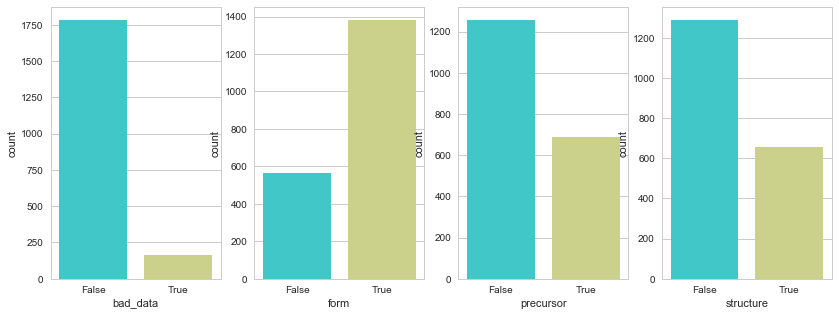

In [154]:
branches = ['bad_data', 'form', 'precursor', 'structure']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,5))

for n in range(4): # max number of classes is 9, but we have only 6 now
    br = branches[n]
    sns.countplot(x=br, data=df_work, palette='rainbow', ax=axes[n])
    
    

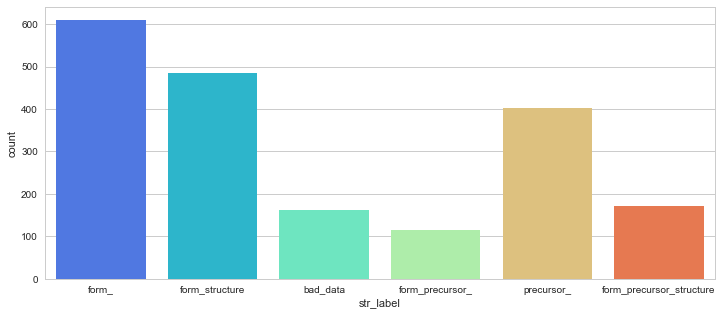

In [155]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,5))
sns.countplot(data=df_work, x='str_label',palette='rainbow')

## Splitting Data into training and testing sets

We have only 1946 samples, thus, I am going to use cross validation.

In [156]:
shuffled_rows = np.random.permutation(df_work.index)
df_work = df_work.loc[shuffled_rows]

In [157]:
train = df_work.iloc[ : 1746]
test = df_work.iloc[1746: ]

Our goal is to predict four labels "bad_data," "form," "precursor," and "structure."

When a sample have "bad_data" : True, it must have "False" for other three labels. 

When a sample have "bad_data" : False, it can have any combinations of other labels.

Thus, I am going to create a binary classificaton for every type of labels. The "form," "precursor," and "structure" classification will be used only for data with "bad_data" : False label.

In [158]:
train.shape

(1746, 114)

In [159]:
test.shape

(200, 114)

In [160]:
# I want to save the split and use it late for testing of unsupervised models
train.to_pickle('paws_train.pkl')
test.to_pickle('paws_test.pkl')

In [161]:
features_analytical = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq',
       'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio',
       'log_fluctuation']

features60 = ['0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 
        # since q is in range 0 - 0.6, we have only zeros in "60" - "99"

features_analytical_and_60 = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq',
       'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio',
       'log_fluctuation','0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59' ]

features = [features_analytical, features60,  features_analytical_and_60]


sklearn.linear_model.SGDClassifier can works as **Logistic Regression**, linesr **SVM**, and **Perceptron** depending on the "loss" parametr.

I choose this classifier since it has the **partial_fit** method.It allows us to update the model using only some new data.

This estimator implements regularized linear models with stochastic gradient descent learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate. 

For best results the data should have zero mean and unit variance (we need to use a scaler).

**StandardScaler** "standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [162]:
scaler_demo = preprocessing.StandardScaler()
data = [[10, 0], [-5, 0], [3, 1], [6, 1]]
scaler_demo.fit(data)
print("mean before transformanion: ", scaler_demo.mean_)
transformed_data = scaler_demo.transform(data)
print("transformed data: \n", transformed_data)
print()
print("transformed data mean [0]: ", transformed_data[ : , 0].mean())
print("transformed data mean [1]: ", transformed_data[ : , 1].mean())
print("transformed std [0]: ", transformed_data[ : , 0].std())
print("transformed std [1]: ", transformed_data[ : , 1].std())

mean before transformanion:  [ 3.5  0.5]
transformed data: 
 [[ 1.18181818 -1.        ]
 [-1.54545455 -1.        ]
 [-0.09090909  1.        ]
 [ 0.45454545  1.        ]]

transformed data mean [0]:  1.38777878078e-17
transformed data mean [1]:  0.0
transformed std [0]:  1.0
transformed std [1]:  1.0


Thus, StandardScaler() does standartization  - now we have means = 0 and std = 1

In [163]:
# parameters for SGDClassifier()
# loss= log    -> logistic regression
# loss = hinge -> linear SVM
# loss = perceptron -> perceptron
parameters = {'loss':('hinge', 'log', 'perceptron'), #default hinge
              'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

## Bad Data

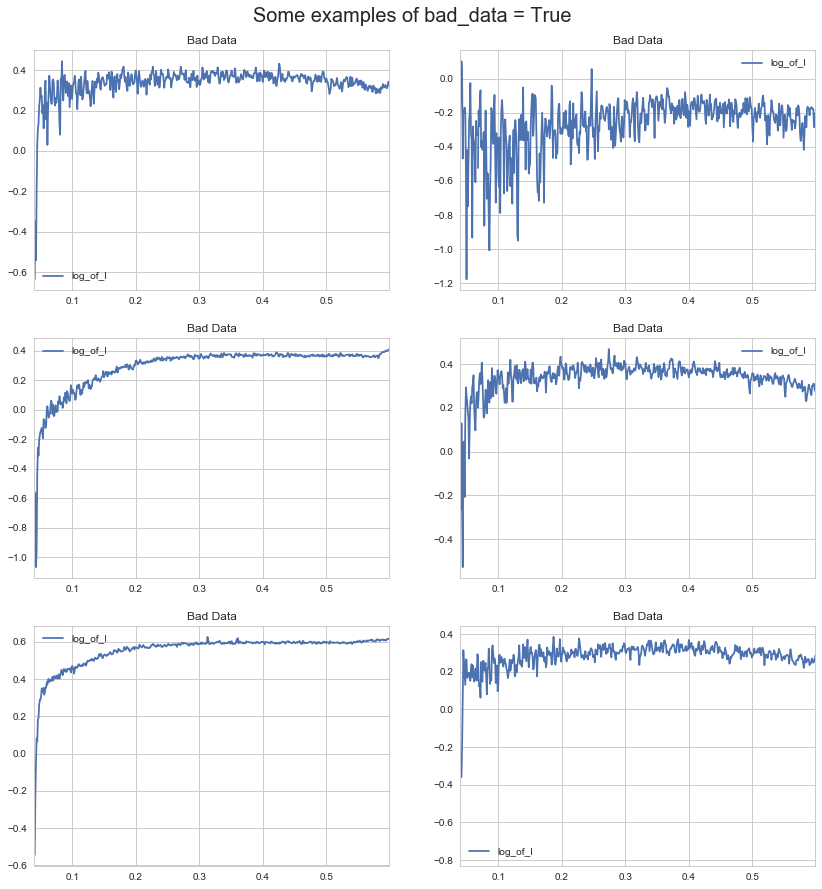

In [164]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Some examples of bad_data = True", fontsize=20)
st.set_y(0.92)
#fig.tight_layout()

for n in range(6): 
    d = train[train['bad_data'] == True]
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 0]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Bad Data");
    axes[n%3, n%2].xaxis.label.set_visible(False)  

### Using GridSearchCV() for choosing the best parametrs and best feature set for "bad_data" labels:

In [165]:
for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train[feature_set])
    svc = linear_model.SGDClassifier()
    clf = GridSearchCV(svc, parameters, cv=5)
    
    clf.fit(scaler.transform(train[feature_set]), train['bad_data'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test[feature_set]), test['bad_data'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'none'}
Training score:  0.991
Test score:  0.995 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.01, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'l1'}
Training score:  0.992
Test score:  0.990 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '

### Accuracy for Bad_Data label 

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal | Log Regression  | 'alpha': 0.0001, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'none' | 99.1 / 99.5
| 60 bin streght  | Log Regression | 'alpha': 0.01, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'l1' | 99.2 / 99.0
| analitycal + 60 bin streght | Perceptron | 'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'perceptron', 'penalty': 'none' | 99.4 / 99.5






Now let's try use grid search for Logistic Regression only. Logistic Regression is our preferable model since it has partial_fit() and predict_prop().

In [166]:
# parameters for SGDClassifier() - we are using logistic regression only
# loss= log    -> logistic regression
parameters2 = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.75, 0.95], #default 0.15
             }

for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_good[feature_set])
    svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
    clf = GridSearchCV(svc, parameters2, cv=5)
    
    clf.fit(scaler.transform(train[feature_set]), train['bad_data'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test[feature_set]), test['bad_data'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.15, 'penalty': 'l2'}
Training score:  0.991
Test score:  0.995 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.01, 'l1_ratio': 0.75, 'penalty': 'l2'}
Training score:  0.991
Test score:  0.980 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '1

### Accuracy for Bad_Data label 

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal | Log Regression  | 'alpha': 0.001, 'l1_ratio': 0.15, 'penalty': 'l2' | 99.1 / 99.5
| 60 bin streght  | Log Regression | 'alpha': 0.01, 'l1_ratio': 0.75, 'penalty': 'l2' | 99.1 / 98.0
| analitycal + 60 bin streght | Log Regression | 'alpha': 0.01, 'l1_ratio': 0.15, 'penalty': 'elasticnet' | **99.5 / 99.5**

**I will use Logistic Regression with analytical + 60 bins streght as features.**

In [168]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features_analytical_and_60])
log = linear_model.SGDClassifier(alpha= 0.01, l1_ratio= 0.15, loss= 'log', penalty= 'elasticnet')

scores = cross_val_score(log, scaler.transform(train[features_analytical_and_60]), train['bad_data'], cv=5)
print("cross validation score: ", scores.mean())

log.fit(scaler.transform(train[features_analytical_and_60]), train['bad_data'])
test_score = log.score(scaler.transform(test[features_analytical_and_60]), test['bad_data'])
print("test score: ", test_score)

cross validation score:  0.991407257894
test score:  0.99


In [182]:
test['bad_data_pred'] = log.predict(scaler.transform(test[features_analytical_and_60]))

pr = log.predict_proba(scaler.transform(test[features_analytical_and_60]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.5f}".format(x), pr))

test['bad_data_prob_true'] =  pd.to_numeric(formated_pr)

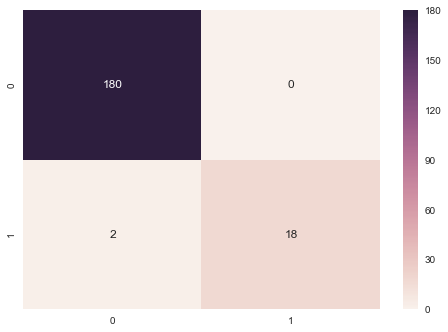

In [183]:
cnf_matrix = confusion_matrix(test['bad_data'], test['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

**We have 2 false negative.**

In [203]:
difference = test[test['bad_data'] != test['bad_data_pred']]
difference[['name', 'str_label','bad_data','bad_data_pred', 'bad_data_prob_true']]

,name,str_label,bad_data,bad_data_pred,bad_data_prob_true
225,R1/R1_reac_0018_dz_bgsub,bad_data,True,False,0.47672
623,R13/R13_0025_dz_bgsub,bad_data,True,False,0.49042


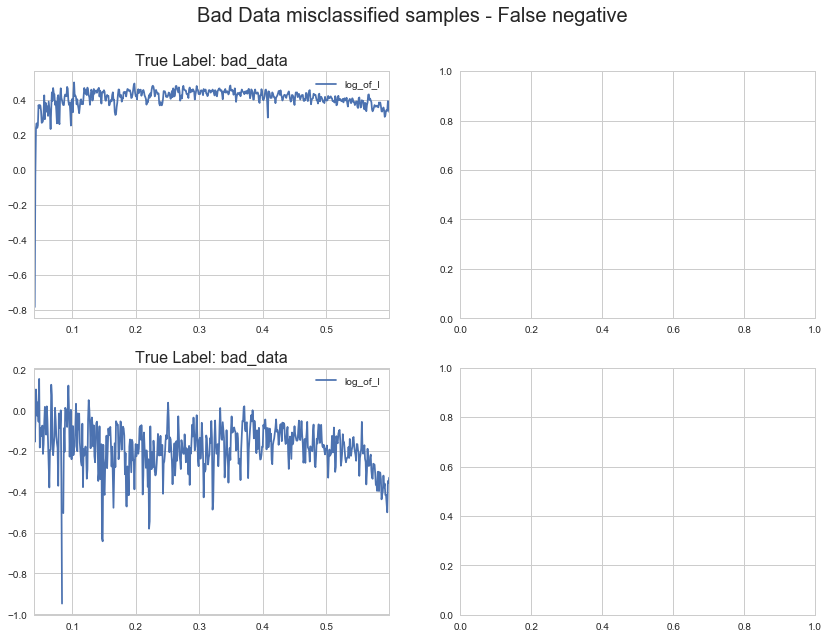

In [204]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Bad Data misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    file_name = d.iloc[0]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

Both misclassified samples have probability to have "bad_data" = True very close to 50%. 

Let's take a look on the others samples that have probability about 50%:

In [188]:
pr_50_50 = test[(test['bad_data_prob_true'] > 0.45) & (test['bad_data_prob_true'] < 0.55)]
pr_50_50.shape

(4, 116)

In [189]:
pr_50_50

,name,q_Imax,Imax_over_Imean,Imax_over_Ilowq,Imax_over_Ihighq,Imax_sharpness,low_q_ratio,high_q_ratio,log_fluctuation,0,...,97,98,99,bad_data,form,precursor,structure,str_label,bad_data_pred,bad_data_prob_true
225,R1/R1_reac_0018_dz_bgsub,0.103,1.219657,1.200252,1.256213,1.290018,0.652774,0.345391,14.148177,0.0,...,0.0,0.0,0.0,True,False,False,False,bad_data,False,0.47672
226,R1/R1_reac_0019_dz_bgsub,0.262,1.297624,1.278298,1.333926,1.207101,0.652095,0.346033,17.052589,0.0,...,0.0,0.0,0.0,True,False,False,False,bad_data,True,0.53214
623,R13/R13_0025_dz_bgsub,0.048,2.096887,2.052897,2.181009,1.530155,0.655708,0.342549,155.719562,0.0,...,0.0,0.0,0.0,True,False,False,False,bad_data,False,0.49042
227,R1/R1_reac_0020_dz_bgsub,0.401,1.375783,1.346274,1.432294,1.310087,0.656482,0.341468,16.296697,0.0,...,0.0,0.0,0.0,True,False,False,False,bad_data,True,0.52426


We have 4 samples with probability to have "bad_data" = True between 45% and 55% and two of them were misclassified.

### Now we will use only samples that have label "bad_data" : False

In [190]:
#now we need only "good" data
train_good = train[train['bad_data']==False]
train_good.shape

(1604, 114)

In [191]:
test_good = test[test['bad_data_pred']==False]
test_good.shape

(182, 116)

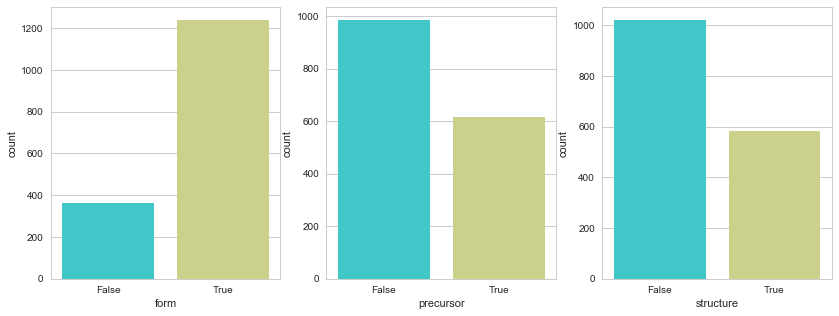

In [192]:
branches = ['form', 'precursor', 'structure']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

for n in range(3):
    br = branches[n]
    sns.countplot(x=br, data=train_good, palette='rainbow', ax=axes[n])

## Form Label
### I am using GridSearchCV() again for choosing the best parametrs and best feature set for "form" labels. 

Since Logistic Regression has partial_fit() and predict_prop() I will try to get a good result using only logistic Regression.

In [194]:
# parameters for SGDClassifier() - we are using logistic regression only
# loss= log    -> logistic regression
parameters2 = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.75, 0.95], #default 0.15
             }

for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_good[feature_set])
    svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
    clf = GridSearchCV(svc, parameters2, cv=5)
    
    clf.fit(scaler.transform(train_good[feature_set]), train_good['form'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test_good[feature_set]), test_good['form'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'elasticnet'}
Training score:  0.992
Test score:  0.978 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
Training score:  0.998
Test score:  0.995 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',

### Accuracy for Form label using Logistic Regresson

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal |Log Reg  | 'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'elasticnet' | 99.2 / 97.8
| 60 bin streght  | Log Reg | 'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'l2' | **99.8 / 99.5**
| analitycal + 60 bin streght | Log Reg | 'alpha': 0.0001, 'l1_ratio': 0, 'penalty': 'l1' | 99.8 / 98.9

In [195]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features60])
log = linear_model.SGDClassifier(alpha= 0.001, l1_ratio= 0, loss= 'log', penalty= 'l2')

scores = cross_val_score(log, scaler.transform(train_good[features60]), train_good['form'], cv=5)
print("cross validation score: ", scores.mean())

log.fit(scaler.transform(train_good[features60]), train_good['form'])
test_score = log.score(scaler.transform(test_good[features60]), test_good['form'])
print("test score: ", test_score)

cross validation score:  0.996882788162
test score:  0.994505494505


In [197]:
test_good['form_pred'] = log.predict(scaler.transform(test_good[features60]))

pr = log.predict_proba(scaler.transform(test_good[features60]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['form_prob_true'] = pd.to_numeric(formated_pr)

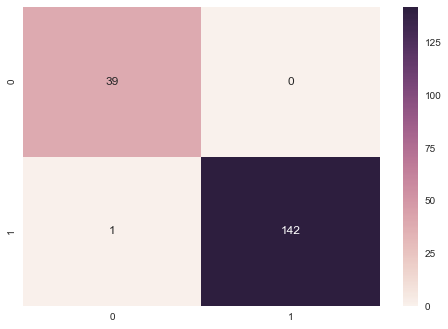

In [198]:
cnf_matrix = confusion_matrix(test_good['form'], test_good['form_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

**We have one false negative**

In [200]:
difference = test_good[test_good['form'] != test_good['form_pred']]
difference[['name', 'str_label','form','form_pred', 'form_prob_true']]

,name,str_label,form,form_pred,form_prob_true
1225,R5/R5_SAXS_0029_dz_bgsub,form_precursor_,True,False,0.001271


In [201]:
pr_50_50 = test_good[(test_good['form_prob_true'] > 0.45) & (test_good['form_prob_true'] < 0.55)]
pr_50_50.shape

(0, 118)

In this case, the probability is not very useful. The misclassified sample has probability to have "form" = True almost %. Also, we do not have samples with predicted probability about 50%

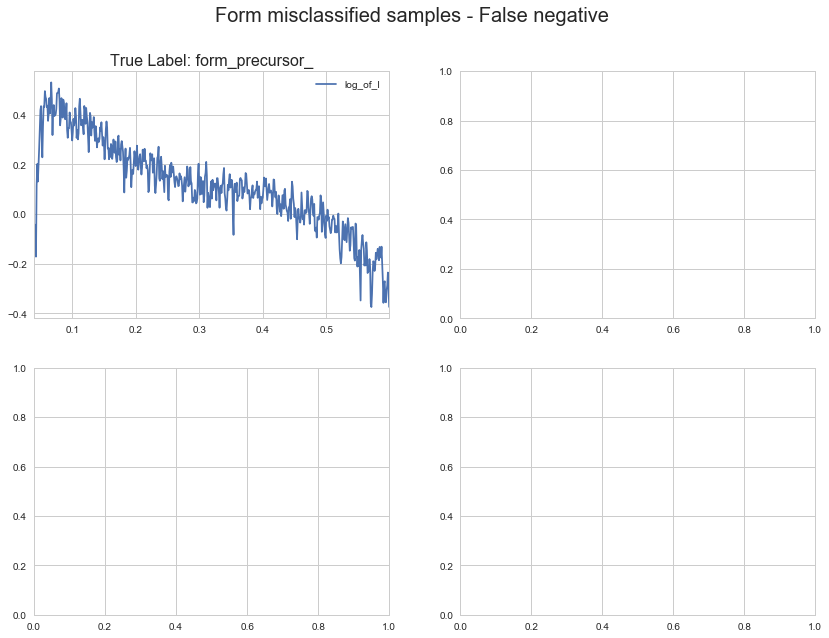

In [202]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Form misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    file_name = d.iloc[0]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

## Precursor Label

Let's start using logistic regression only:

In [205]:
for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_good[feature_set])
    svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
    clf = GridSearchCV(svc, parameters2, cv=5)
    
    clf.fit(scaler.transform(train_good[feature_set]), train_good['precursor'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test_good[feature_set]), test_good['precursor'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.95, 'penalty': 'l1'}
Training score:  0.907
Test score:  0.863 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.5, 'penalty': 'l1'}
Training score:  0.945
Test score:  0.923 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '1

### Accuracy for Precursor label using Logistic Regression

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal |Log Reg  | 'alpha': 0.001, 'l1_ratio': 0.95, 'penalty': 'l1'| 90.7 / 86.3
| 60 bin streght  | Log Reg | 'alpha': 0.001, 'l1_ratio': 0.5, 'penalty': 'l1' | 94.5 / 92.3
| analitycal + 60 bin streght | Log Reg | 'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'none' | **94.8 / 95.6**

In [206]:
for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_good[feature_set])
    svc = linear_model.SGDClassifier()
    clf = GridSearchCV(svc, parameters, cv=5)
    
    clf.fit(scaler.transform(train_good[feature_set]), train_good['precursor'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test_good[feature_set]), test_good['precursor'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'log', 'penalty': 'l1'}
Training score:  0.909
Test score:  0.852 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'hinge', 'penalty': 'l1'}
Training score:  0.946
Test score:  0.923 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',

### Accuracy for Precursor label using Logistic Regresson, SVM, and Perceptron

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal |Log Reg  | 'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'log', 'penalty': 'l1' | 90.9 / 85.2
| 60 bin streght  | SVM | 'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'hinge', 'penalty': 'l1' | 94.6 / 92.3
| analitycal + 60 bin streght | SVM | 'alpha': 0.001, 'l1_ratio': 0.95, 'loss': 'hinge', 'penalty': 'none' | 94.8 / 92.9

**I will use Logistic Regression with analytical + 60 bins streght as features.**

In [208]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features_analytical_and_60])
log = linear_model.SGDClassifier(alpha= 0.001, l1_ratio= 0, loss= 'log', penalty= 'none')

scores = cross_val_score(log, scaler.transform(train_good[features_analytical_and_60]), train_good['precursor'], cv=5)
print("cross validation score: ", scores.mean())

log.fit(scaler.transform(train_good[features_analytical_and_60]), train_good['precursor'])
test_score = log.score(scaler.transform(test_good[features_analytical_and_60]), test_good['precursor'])
print("test score: ", test_score)

cross validation score:  0.942026651477
test score:  0.950549450549


In [209]:
test_good['precursor_pred'] = log.predict(scaler.transform(test_good[features_analytical_and_60]))

pr = log.predict_proba(scaler.transform(test_good[features_analytical_and_60]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['precursor_prob_true'] = pd.to_numeric(formated_pr)

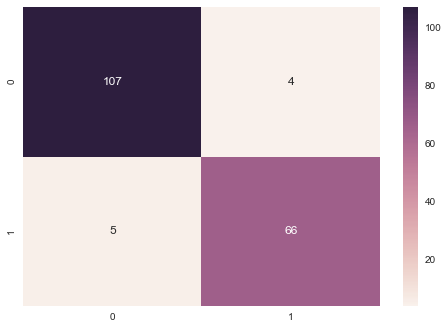

In [210]:
cnf_matrix = confusion_matrix(test_good['precursor'], test_good['precursor_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 5 false negative and 4 false positive.

In [211]:
difference = test_good[test_good['precursor'] != test_good['precursor_pred']]
difference[['name', 'str_label','precursor','precursor_pred', 'precursor_prob_true']]

,name,str_label,precursor,precursor_pred,precursor_prob_true
1545,Reaction_A/A_colling_60C_0212122720_0001_dz_bgsub,form_structure,False,True,0.983204
1244,R5/R5_SAXS_0048_dz_bgsub,form_precursor_structure,True,False,0.001567
225,R1/R1_reac_0018_dz_bgsub,bad_data,False,True,1.000000
1485,Reaction_A/A_245C_0212114602_0001_dz_bgsub,form_precursor_,True,False,0.104781
1796,Reaction_E/E_270C_0213202445_0001_dz_bgsub,form_precursor_,True,False,0.000268
633,R13/R13_0035_dz_bgsub,form_,False,True,0.805752
1908,Reaction_H/H_267C_0214203619_0001_dz_bgsub,form_precursor_,True,False,0.153013
1495,Reaction_A/A_272C_0212115023_0001_dz_bgsub,form_structure,False,True,0.999950
1905,Reaction_H/H_263C_0214203533_0001_dz_bgsub,form_precursor_,True,False,0.002720


**No one form the misclassified samples has probability about 50/50**

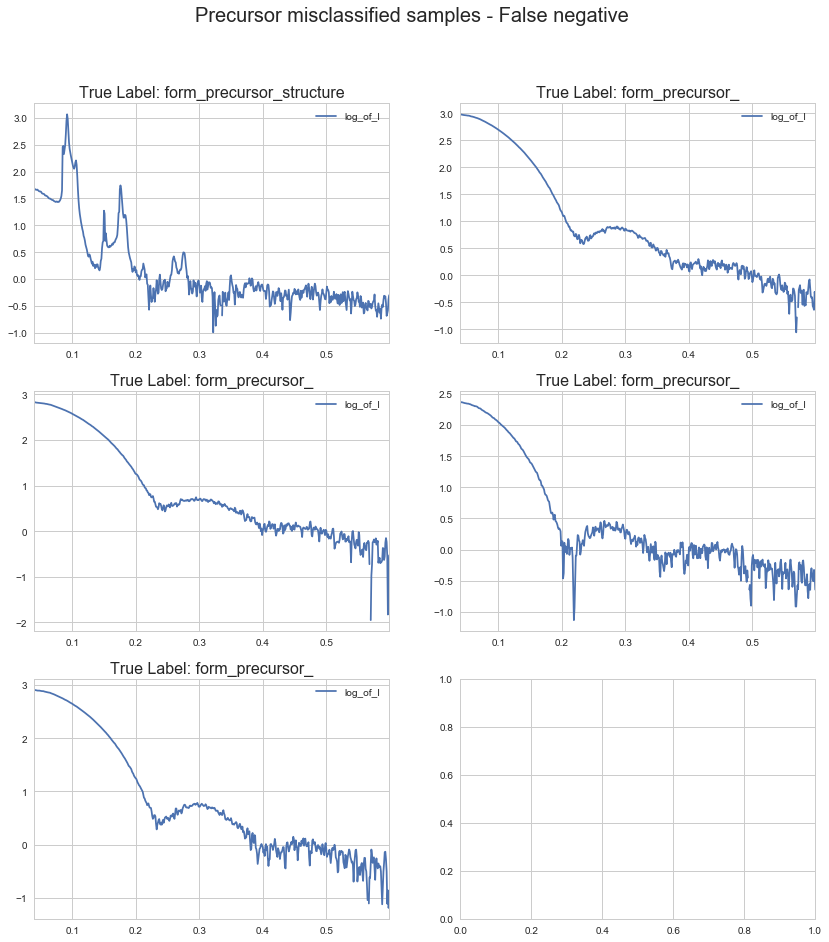

In [212]:
false_negative = difference[difference['precursor'] == True]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(len(false_negative)): 
    d = false_negative.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

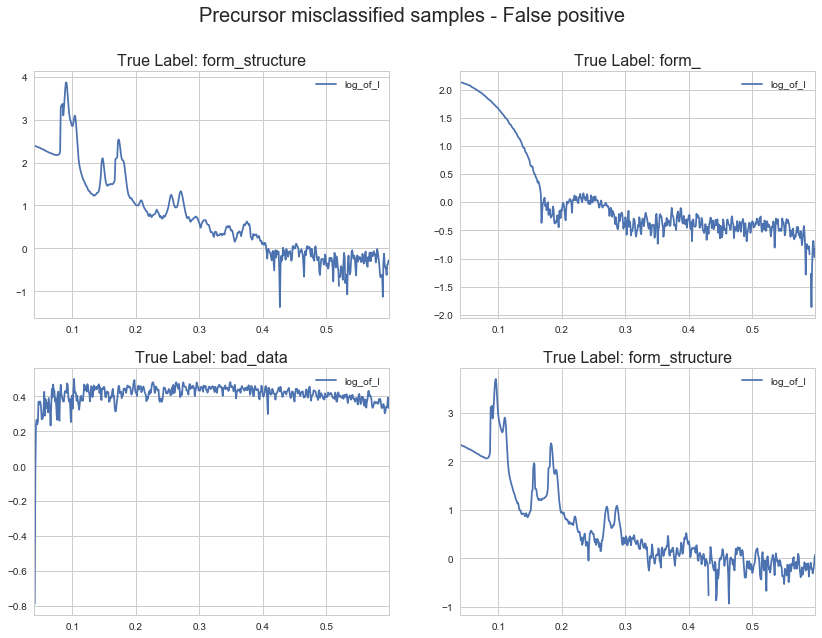

In [213]:
false_positive = difference[difference['precursor'] == False]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Precursor misclassified samples - False positive", fontsize=20)
st.set_y(0.97)

for n in range(len(false_positive)): 
    d = false_positive.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

## Structure Label
I will start with Logistic Regression again:

In [214]:
for feature_set in features:
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_good[feature_set])
    svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
    clf = GridSearchCV(svc, parameters2, cv=5)
    
    clf.fit(scaler.transform(train_good[feature_set]), train_good['structure'])
    print(feature_set, "\n")
    print("Best parameters set found on training set:")
    print(clf.best_params_)
    
    print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set
    
    test_score = clf.score(scaler.transform(test_good[feature_set]), test_good['structure'])
    print("Test score: ", "%0.3f" % test_score, "\n")

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation'] 

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'penalty': 'none'}
Training score:  0.973
Test score:  0.929 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.15, 'penalty': 'none'}
Training score:  0.988
Test score:  0.995 

['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio', 'log_fluctuation', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '1

### Accuracy for Structure label using Logistic Regression

| features | model | parametrs |  accuracy training set / test set
| ------------- | ------------- |----------------
| analitycal |Log Reg  | 'alpha': 0.0001, 'l1_ratio': 0.5, 'penalty': 'none' | 97.3 / 92.9
| 60 bin streght  | Log Reg | 'alpha': 0.0001, 'l1_ratio': 0.15, 'penalty': 'none' | 98.8 / 99.5
| analitycal + 60 bin streght | Log Reg | 'alpha': 0.0001, 'l1_ratio': 0.95, 'penalty': 'none' | **98.7 / 99.5**

In [215]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features_analytical_and_60])
log = linear_model.SGDClassifier(alpha= 0.0001, l1_ratio= 0.95, loss= 'log', penalty= 'none')

scores = cross_val_score(log, scaler.transform(train_good[features_analytical_and_60]), train_good['structure'], cv=5)
print("cross validation score: ", scores.mean())

log.fit(scaler.transform(train_good[features_analytical_and_60]), train_good['structure'])
test_score = log.score(scaler.transform(test_good[features_analytical_and_60]), test_good['structure'])
print("test score: ", test_score)

cross validation score:  0.966981942106
test score:  0.994505494505


In [216]:
test_good['structure_pred'] = log.predict(scaler.transform(test_good[features_analytical_and_60]))

pr = log.predict_proba(scaler.transform(test_good[features_analytical_and_60]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['structure_prob_true'] = pd.to_numeric(formated_pr)

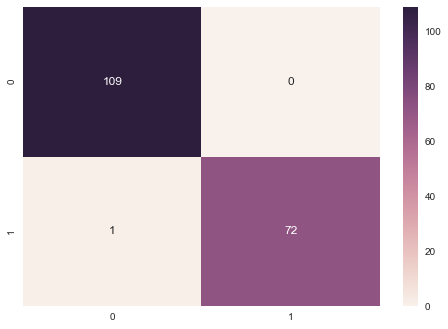

In [217]:
cnf_matrix = confusion_matrix(test_good['structure'], test_good['structure_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 1 false negative.

In [218]:
difference = test_good[test_good['structure'] != test_good['structure_pred']]
difference[['name', 'str_label','structure','structure_pred', 'precursor_prob_true']]

,name,str_label,structure,structure_pred,precursor_prob_true
785,R2/R2_SAXS_0039_dz_bgsub,form_precursor_structure,True,False,1.0


**Out model was 100% sure that the label shoud be "False," but the true label is "True"**

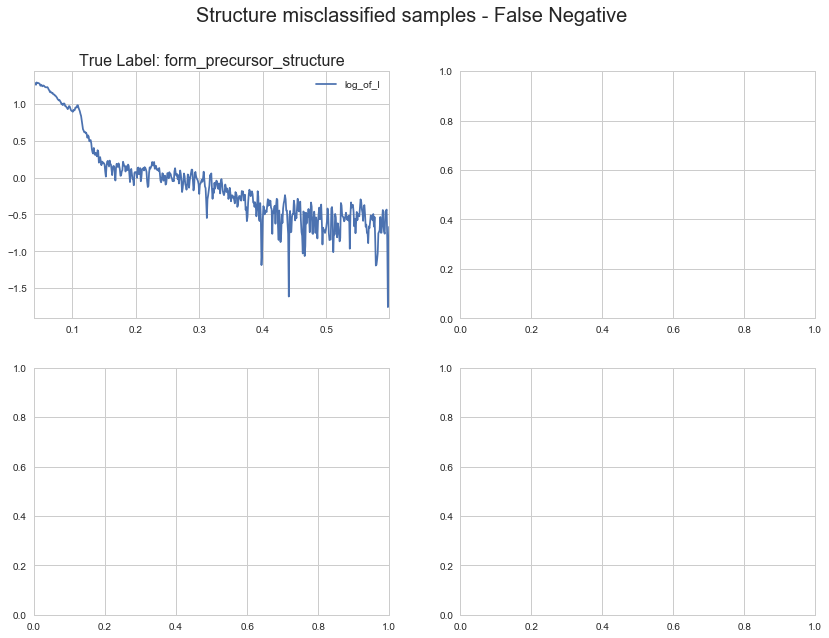

In [219]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Structure misclassified samples - False Negative", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    file_name = d.iloc[0]
    str_label = difference.iloc[n]['str_label']
    pred_str = difference.iloc[n]['structure_pred']
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label , fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

## Results

### Accuracy of Logistic Regression classifiers vs the best result from unsupervised classifiers

|            | feature set | accuracy on testing set |  the accuracy of the best unsupervised classifier on the same testing set
| ------------- | ------------- |----------------
| bad_data  | analytical features + 60 bins strengths  | 0.990 | 0.970
| form  | 60 bins strengths  | 0.995 | 0.859
| precursor | analytical features + 60 bins strengths | 0.951 | 0.814
| structure | analytical features + 60 bins strengths | 0.995 | 0.983

The result that we got using supervised learning is significant better than we got using unsupervised learning. 

"Probability" is useful for "Bad Data" label - we had about the same probability for have "True" and "False" for misclassified samples.